# 1. Business Understanding

## 1.1. Objetivo de Negócio
* **Minimizar Perdas Financeiras:** O foco principal é reduzir prejuízos decorrentes de fraudes (*chargebacks*), dado o contexto de decisão em tempo real

* **Premissa de Custo:** Assumimos que o custo de aprovar uma fraude (Falso Negativo) é significativamente superior ao de negar uma transação legítima

* **Restrição Operacional:** O desafio é reduzir as perdas mantendo o atrito com clientes legítimos (bloqueios indevidos/Falsos Positivos) em um **nível aceitável**, sem prejudicar a experiência de uso


## 1.2. Objetivo de Modelagem

1. **Priorização do Recall (Minimização de Falsos Negativos):**
    O modelo será otimizado para maximizar o **Recall**, visando detectar a maior quantidade possível de fraudes. Contudo, buscaremos um equilíbrio onde a taxa de Falsos Positivos permaneça controlada, evitando o bloqueio excessivo de bons clientes.

2. **Minimização do Prejuízo Financeiro (Pesos via `ratio_to_median`):**
 Utilizaremos a variável `ratio_to_median_purchase_price` para ponderar o risco financeiro. A estratégia é aplicar maior rigor em transações de alto valor (que fogem da mediana). Assim, caso o modelo falhe em detectar uma fraude (Falso Negativo), garantimos que esse erro ocorra preferencialmente em transações de **baixo valor**, protegendo o capital nas transações de maior risco.

-------------

# 2. Data Understanding

In [1]:
# 1. Manipulação de Dados e Numéricos
import pandas as pd
import numpy as np

# 2. Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Scikit-Learn: Pré-processamento e Seleção de Modelos
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# 4. Algoritmos de Machine Learning
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 5. Métricas de Avaliação
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
# Carregamento dos Dados
df = pd.read_csv('dataset.csv') # Exemplo

## 2.1. Estrutura dos Dados e Verificação de Nulos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


**Conclusão:** A análise da estrutura revela que o dataset não possui variáveis categóricas (strings/objects); todas as features são numéricas (contínuas) ou binárias (0/1). Além disso, verificou-se que não existem valores nulos no conjunto de dados

## 2.2. Análise Estatística das Variáveis Contínuas
Focamos agora nas estatísticas descritivas das principais variáveis contínuas (`distance_from_home`, `distance_from_last_transaction` e `ratio_to_median_purchase_price`) para entender a distribuição central e a dispersão dos dados.

In [4]:
df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


**Conclusão e Hipótese:**
Ao observar a tabela acima, notamos um padrão consistente de **Cauda Longa (Long Tail)** à direita em todas as variáveis: a **média é muito superior à mediana**.

* Ex: Em `ratio_to_median_purchase_price`, a mediana é ~0.99, enquanto a média sobe para ~1.82, impulsionada por valores máximos extremos (max = 267.8).

Isso indica que existem transações com valores que fogem drasticamente do padrão habitual. Diante disso, surge uma pergunta crucial para a nossa estratégia de modelagem:

> **Pergunta:** *Esses valores extremos são apenas "outliers" (ruídos/erros) que devem ser removidos para limpar os dados, ou eles representam justamente o padrão de comportamento das fraudes que queremos detectar?*

## 2.3. Investigação da Cauda Longa: Ruído ou Sinal?

Para responder à pergunta levantada na etapa anterior, vamos visualizar a distribuição dessas variáveis separando os dados por classe: **Legítima (0)** vs **Fraude (1)**.

### 2.3.1 Comparando o comportamento da variável `distance_from_home`

In [5]:
# Agrupando e exibindo estatísticas focadas
print("--- distance_from_home ---")
df.groupby('fraud')['distance_from_home'].describe().T

--- distance_from_home ---


fraud,0.0,1.0
count,912597.000000,87403.000000
mean,22.832976,66.261876
std,52.828655,134.391608
min,0.004874,0.025847
25%,3.828942,4.585729
50%,9.673847,15.454219
75%,24.158057,101.110104
max,8777.136420,10632.723672


### 2.3.2 Comparando o comportamento da variável `distance_from_last_transaction`

In [6]:
# Agrupando e exibindo estatísticas focadas
print("--- distance_from_last_transaction ---")
df.groupby('fraud')['distance_from_last_transaction'].describe().T

--- distance_from_last_transaction ---


fraud,0.0,1.0
count,912597.000000,87403.000000
mean,4.301391,12.712185
std,22.472359,47.997697
min,0.000118,0.000407
25%,0.293859,0.328199
50%,0.985074,1.157631
75%,3.268578,4.598504
max,11851.104565,2160.499922


### 2.3.3 Comparando o comportamento da variável `ratio_to_median_purchase_price`

In [7]:
# Agrupando e exibindo estatísticas focadas
print("--- distance_from_last_transaction ---")
df.groupby('fraud')['ratio_to_median_purchase_price'].describe().T

--- distance_from_last_transaction ---


fraud,0.0,1.0
count,912597.000000,87403.000000
mean,1.423642,6.006323
std,1.946152,5.564320
min,0.004399,0.011966
25%,0.449768,3.500270
50%,0.913950,5.071294
75%,1.788918,7.331222
max,267.802942,266.689692


**Conclusão da Análise de Variáveis Contínuas**

A análise comparativa revela um padrão comportamental distinto entre as classes:

1.  **Padrão de Valores Elevados:** As transações fraudulentas (1) apresentam consistentemente médias e medianas muito superiores às transações legítimas (0) nas três variáveis analisadas.
    * Exemplo crítico: O `ratio_to_median_purchase_price` nas fraudes tem mediana ~5x maior que nas transações legítimas.

2.  **Decisão sobre Outliers:**
    * Os valores extremos observados (cauda longa) **não são ruídos**, mas sim características intrínsecas ao comportamento fraudulento.
    
    * **Ação:** Não removeremos esses outliers. A exclusão desses dados removeria o próprio sinal que estamos tentando detectar. O modelo deverá ser capaz de aprender que valores altos nessas variáveis aumentam a probabilidade de fraude.

### 2.4. Distribuição da Variável Alvo (Desbalanceamento)

Para finalizar o entendimento dos dados, analisamos a proporção entre transações legítimas e fraudulentas.

A visualização dessa discrepância é fundamental para confirmarmos o grau de desbalanceamento do dataset, o que ditará a estratégia de validação do modelo (evitando métricas enganosas como a Acurácia global).

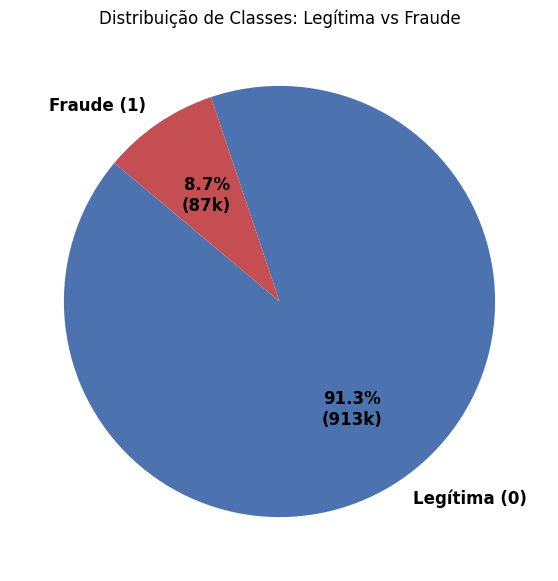

In [8]:
# Preparando os dados
counts = df['fraud'].value_counts()
labels = [f'Legítima (0)', f'Fraude (1)']
colors = ['#4c72b0', '#c44e52'] # Azul e Vermelho suaves

# Função para formatar o texto interno: Porcentagem + Quantidade em 'k'
def formatar_label(pct, all_vals):
    absolute = int(pct/100.*sum(all_vals))
    # Transforma 87000 em 87k, 913000 em 913k
    val_fmt = f"{absolute/1000:.0f}k"
    return f"{pct:.1f}%\n({val_fmt})"

# Plotando o Gráfico de Pizza
plt.figure(figsize=(7, 7))
plt.pie(counts,
        labels=labels,
        colors=colors,
        autopct=lambda pct: formatar_label(pct, counts),
        startangle=140,
        textprops={'fontsize': 12, 'weight': 'bold'})

plt.title('Distribuição de Classes: Legítima vs Fraude')
plt.show()

**Conclusão do Desbalanceamento:**

A análise gráfica confirma um desbalanceamento significativo no conjunto de dados:
* **Legítimas (0):** Representam a vasta maioria das transações (~91.3%).
* **Fraudes (1):** Representam uma minoria (~8.7%).

**Impacto no Projeto:**
Este cenário confirma a necessidade das definições feitas na etapa de *Business Understanding*:
1.  **Métricas:** Não podemos usar a Acurácia (Accuracy) como métrica principal, pois um modelo que dissesse "tudo é legítimo" teria 91% de acurácia, mas falharia em 100% das fraudes.
2.  **Foco:** O modelo precisa ser penalizado especificamente quando erra a classe minoritária (1), validando o uso de **Recall** e **F2-Score**.

------

# 3. Data Preparation

Nesta etapa, implementamos a estrutura de processamento dos dados focada em produção.

### Conceito: Pipeline End-to-End
Adotamos uma abordagem onde o pré-processamento e o modelo de previsão são encapsulados em um único objeto (Pipeline):
1.  **Abstração:** O sistema em produção receberá os dados brutos e o pipeline se encarregará de todas as transformações necessárias automaticamente.
2.  **Reprodutibilidade:** Garantimos que os dados de novos clientes passem exatamente pelas mesmas regras matemáticas aplicadas no treino, eliminando discrepâncias.

### Execução: O que foi feito
Para concretizar essa estratégia, realizamos as seguintes etapas técnicas:

* **1. Divisão dos Dados (Holdout Stratified):**
    Separamos os dados em Treino (80%) e Teste (20%) **antes** de qualquer transformação para evitar o vazamento de dados (*Data Leakage*).

* **2. Tratamento de Variáveis (ColumnTransformer):**
    Como o pipeline precisa ser robusto a falhas de dados (nulos) em tempo real, definimos tratamentos específicos por tipo de coluna:

    * **Variáveis Numéricas:** Aplicamos a imputação de valores nulos utilizando a **Média**, seguida de **Padronização (`MinMaxScaler`)** para colocar todas as grandezas na mesma escala.

    * **Variáveis Binárias:** Aplicamos a imputação de nulos preenchendo com **Zero (0)**, assumindo a ausência de informação como a negativa da flag binária.

### 3.1 Divisão dos Dados

In [9]:
# 1. Separação de Features (X) e Target (y)
X = df.drop(columns=['fraud'])
y = df['fraud']

# 2. Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Dimensões do Treino: {X_train.shape}")
print(f"Dimensões do Teste:  {X_test.shape}")

Dimensões do Treino: (800000, 7)
Dimensões do Teste:  (200000, 7)


### 3.2 Construção do Preprocessador

In [10]:
# 1. Definição das colunas por tipo
numeric_features = [
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price'
]

binary_features = [
    'repeat_retailer',
    'used_chip',
    'used_pin_number',
    'online_order'
]

# 2. Criação dos Pipelines de Transformação

# Numérico: Imputa média -> Padroniza a escala
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Binário: Imputa 0 (constante) em caso de nulos
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# 3. Consolidação no Pré-processador (ColumnTransformer)
preprocessing = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features)
    ]
)

preprocessing

,transformers,"[('num', ...), ('bin', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


-------------

# 4. Modeling

Nesta etapa, adotaremos uma abordagem evolutiva para testar três hipóteses de modelagem, aumentando progressivamente a complexidade do algoritmo e a inteligência de negócio embutida.

### 4.1. Definição das Hipóteses e Modelos

* **Modelo 1: Regressão Logística (Baseline Linear)**
    * **Configuração:** Padrão, sem pesos.
    * **Hipótese:** Serve apenas como linha de base. Esperamos que tenha dificuldade em capturar padrões complexos de fraude não-lineares.

* **Modelo 2: XGBoost Classifier (Baseline Não-Linear)**
    * **Configuração:** XGBoost padrão, sem ajustes de pesos.
    * **Hipótese de Algoritmo:** Acreditamos que o XGBoost será superior à Regressão Logística. Por ser um algoritmo baseado em *Gradient Boosting* (árvores de decisão sequenciais), ele consegue capturar relações não-lineares complexas que a regressão ignora.

* **Modelo 3: Cost-Sensitive XGBoost (Hipótese de Negócio)**
    * **Configuração:** XGBoost com "Dupla Ponderação".
    * **Hipótese Financeira:** Acreditamos que um modelo tecnicamente superior (Modelo 2) ainda pode ser melhorado se "ensinarmos" a ele o custo do erro.
        1.  **Peso de Classe (`scale_pos_weight`):** Para corrigir o desbalanceamento natural (9:1).
        2.  **Peso da Amostra (Financeiro):** Usaremos o `ratio_to_median` como peso de cada linha durante o treinamento. Isso força o algoritmo a priorizar o acerto nas fraudes de alto valor (maior prejuízo), mesmo que para isso sacrifique precisão em valores irrisórios.

In [11]:
# Dicionário para armazenar os modelos treinados
models = {}

# ---------------------------------------------------------
# MODELO 1: Regressão Logística (Baseline Linear)
# ---------------------------------------------------------
print("--- Treinando Modelo 1: Logistic Regression (Baseline) ---")
model_1 = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(random_state=1))
])
model_1.fit(X_train, y_train)
models['Logistic Regression'] = model_1



# ---------------------------------------------------------
# MODELO 2: XGBoost Simples
# ---------------------------------------------------------
print("\n--- Treinando Modelo 2: XGBoost (Simples) ---")
# O XGBoost lida muito bem com dados tabulares complexos
model_2 = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', XGBClassifier(random_state=1))
])
model_2.fit(X_train, y_train)
models['XGBoost Simples'] = model_2



# ---------------------------------------------------------
# MODELO 3: XGBoost Cost-Sensitive (Inteligência Financeira)
# ---------------------------------------------------------
print("\n--- Treinando Modelo 3: XGBoost (Cost-Sensitive) ---")

# 1. Cálculo do scale_pos_weight para balanceamento de classes
ratio_balance = (y_train == 0).sum() / (y_train == 1).sum()

# 2. Definição dos Pesos Financeiros (Sample Weights)
sample_weights = X_train['ratio_to_median_purchase_price'].copy()

model_3 = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', XGBClassifier(
        random_state=1,
        scale_pos_weight=ratio_balance # Corrige o desbalanceamento (90/10)
    ))
])

# Passamos os pesos financeiros especificamente para o classificador dentro do pipeline
model_3.fit(X_train, y_train, classifier__sample_weight=sample_weights)
models['XGBoost Weighted'] = model_3

model_3

--- Treinando Modelo 1: Logistic Regression (Baseline) ---

--- Treinando Modelo 2: XGBoost (Simples) ---

--- Treinando Modelo 3: XGBoost (Cost-Sensitive) ---


,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


------------

# 5. Evaluation

Nesta etapa, avaliamos os modelos sob quatro perspectivas distintas para validar qual solução traz o maior retorno real para o negócio.

# 5. Evaluation

Nesta etapa, avaliamos os modelos. Seguindo as boas práticas, primeiro verificamos a estabilidade do treinamento (dentro dos dados de treino) e só depois avaliamos a performance final nos dados de teste (dados nunca vistos).

### 5.1. Validação de Robustez (Cross-Validation)
Antes de confiarmos nos resultados finais, precisamos garantir que os modelos não sofreram **Overfitting** .
Para isso, aplicamos validação cruzada com 5 dobras (*folds*) nos dados de treino.

* **Expectativa:** Se o **Desvio Padrão** for baixo, o modelo é robusto e estável. Se for alto, o modelo é inconfiável.

In [12]:
# Configuração: 10 Folds estratificados (mantém a proporção de fraudes)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = []

print(" Executando Cross-Validation (10 Folds)")

for name, model in models.items():
    # Avaliando Recall (nossa métrica principal)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
    
    cv_results.append({
        'Model': name,
        'Média Recall': scores.mean(),
        'Desvio Padrão': scores.std(), # Quanto menor, mais estável
        'Min Recall': scores.min(),
        'Max Recall': scores.max()
    })

df_cv = pd.DataFrame(cv_results).set_index('Model')
print("Verificação de Estabilidade (Base de Treino):")
display(df_cv)

 Executando Cross-Validation (10 Folds)
Verificação de Estabilidade (Base de Treino):


,Média Recall,Desvio Padrão,Min Recall,Max Recall
Model,,,,
Logistic Regression,0.395841,0.007362,0.380292,0.408324
XGBoost Simples,0.991619,0.001599,0.988272,0.993421
XGBoost Weighted,0.998126,0.000795,0.996281,0.999142


### 5.2. Performance Final (Dados de Teste)

Confirmada a estabilidade, aplicamos os modelos no conjunto de **Teste** (dados que o modelo nunca viu).
Avaliamos as métricas principais:

* **Recall:** Capacidade de detectar fraudes (Prioridade).
* **Precision:** Capacidade de não bloquear clientes legítimos à toa.
* **ROC-AUC:** Qualidade geral de separação.

In [13]:
# 1. Função para extrair métricas
def get_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_prob)
    except:
        roc = 0 

    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall (Fraudes Pegas)': recall_score(y_test, y_pred),
        'Precision (Assertividade)': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc
    }

# 2. Consolidação e Exibição
metrics_list = []
for name, model in models.items():
    metrics_list.append(get_metrics(model, X_test, y_test, name))

df_results = pd.DataFrame(metrics_list).set_index('Model')
print("Tabela de Performance Técnica")
display(df_results)

Tabela de Performance Técnica


,Accuracy,Recall (Fraudes Pegas),Precision (Assertividade),F1-Score,ROC-AUC
Model,,,,,
Logistic Regression,0.945420,0.411819,0.919060,0.568776,0.952094
XGBoost Simples,0.998255,0.991133,0.988927,0.990029,0.999972
XGBoost Weighted,0.999010,0.999028,0.989742,0.994363,0.999984


### 5.3. Visualização dos Erros (Matriz de Confusão)
Plotamos as matrizes de confusão para investigar visualmente o comportamento dos modelos.
* **Objetivo:** Queremos maximizar o canto inferior direito (Verdadeiros Positivos - Fraudes Detectadas) e zerar o canto inferior esquerdo (Falsos Negativos - Fraudes que passaram).

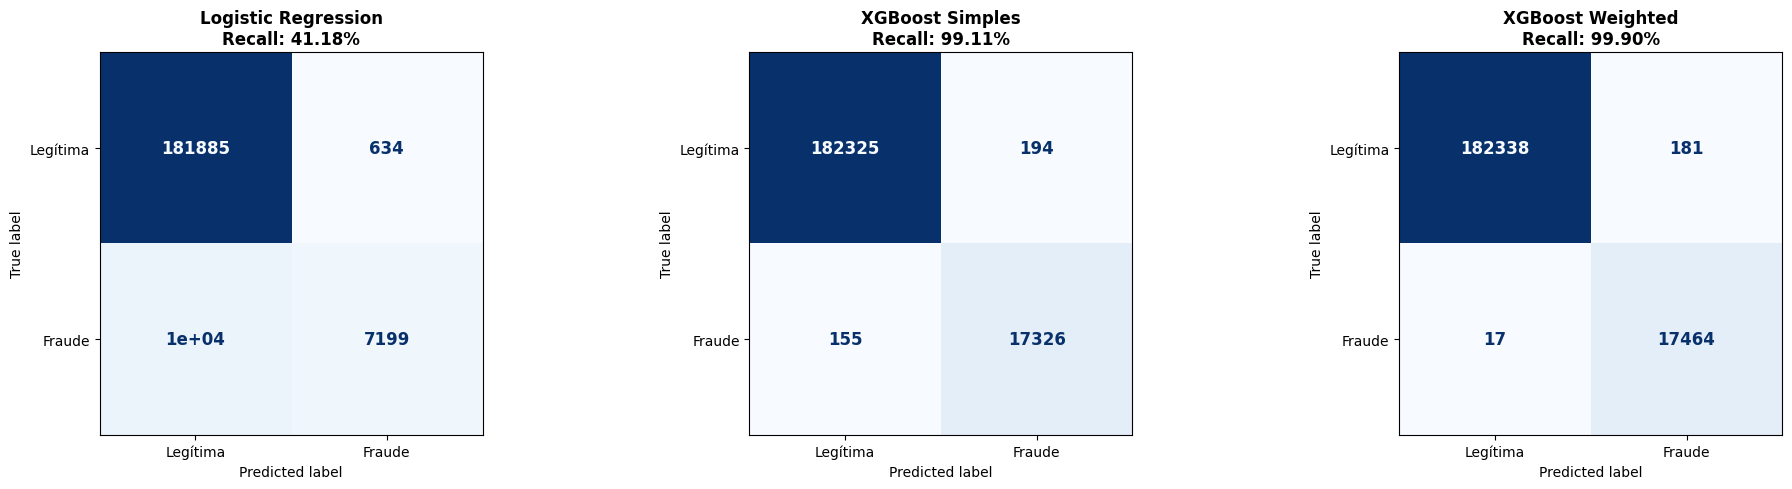

In [14]:
# Plotagem lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    
    # Plota a matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legítima', 'Fraude'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    
    # --- CUSTOMIZAÇÃO DO TEXTO INTERNO ---
    for text in disp.text_.ravel():
        text.set_weight('bold')
        text.set_fontsize(12)    

    # Título com Recall
    rec = recall_score(y_test, model.predict(X_test))
    axes[i].set_title(f'{name}\nRecall: {rec:.2%}', fontweight='bold')

plt.tight_layout()
plt.show()

**Nota Metodológica:** A soma direta da variável ratio é uma simplificação, pois ignora que cada cliente possui uma mediana de gastos diferente (ex: um ratio 4.0 de um cliente de alta renda é financeiramente superior a um ratio 4.0 de um cliente econômico). Adotamos essa métrica apenas para ilustrar a mecânica de redução de prejuízo, dada a ausência do valor absoluto da transação

### 5.4. Validação da Hipótese Financeira
Esta é a análise crítica de negócio. Em vez de olharmos apenas para a quantidade de acertos, olhamos para o **dinheiro**.
Utilizamos a variável `ratio_to_median` como representação do valor monetário para calcular:

1.  **Valor Bloqueado (Economia):** A soma dos valores das fraudes que o modelo detectou corretamente.

2.  **Valor Perdido (Prejuízo):** A soma dos valores das fraudes que o modelo não viu e aprovou indevidamente (Falsos Negativos).

O objetivo é maximizar o valor bloqueado e minimizar o perdido.

In [15]:
# Recuperando os valores ("dinheiro") do conjunto de teste
test_values = X_test['ratio_to_median_purchase_price']

financial_results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Máscaras Booleanas
    mask_fraud_real = (y_test == 1)       # É fraude mesmo
    mask_fraud_pred = (y_pred == 1)       # Modelo disse que é fraude

    # 1. Valor Bloqueado: Fraudes reais que o modelo pegou
    saved_value = test_values[mask_fraud_real & mask_fraud_pred].sum().astype(int)

    # 2. Valor Perdido: Fraudes reais que o modelo deixou passar
    lost_value = test_values[mask_fraud_real & ~mask_fraud_pred].sum().astype(int)

    financial_results.append({
        'Model': name,
        'Valor Bloqueado (Economia)': saved_value,
        'Valor Perdido (Prejuízo)': lost_value
    })

df_financial = pd.DataFrame(financial_results).set_index('Model')

display(df_financial)

,Valor Bloqueado (Economia),Valor Perdido (Prejuízo)
Model,,
Logistic Regression,69667,35449
XGBoost Simples,104546,571
XGBoost Weighted,105029,88


### 5.5. Conclusão da Avaliação

Os resultados confirmam que alinhar a estratégia de modelagem ao objetivo financeiro foi decisivo. Destacamos os pontos-chave que validam o **Modelo 3 (XGBoost Weighted)** como a solução ideal:

* **Superioridade Técnica e Financeira:** O modelo atingiu o maior Recall (**99.9%**) e protegeu quase a totalidade do capital em risco. Enquanto o modelo simples permitiu um "prejuízo" de 571 unidades, o modelo ponderado reduziu isso para apenas **88**.

* **Decisão sobre Outliers:** A estratégia de **não remover outliers** provou-se correta. Os valores extremos identificados na análise exploratória eram, de fato, os sinais das fraudes de alto valor. Removê-los teria cegado o modelo para os maiores riscos.

* **Estabilidade (Robustez):** O desvio padrão ínfimo na validação cruzada (**0.0004**) elimina a suspeita de *Overfitting*. O modelo é estável e seguro para produção.

* **Eficiência de Solução:** Atingimos um resultado de excelência através do entendimento do negócio (pesos financeiros) e boa engenharia de dados, dispensando a necessidade de gastar recursos computacionais com otimizações complexas de hiperparâmetros (*GridSearch*).

----------------

# 6. Deployment & Monitoring (Plano de Produção)

O notebook desenvolvido até aqui serviu como ambiente de pesquisa e validação. Para colocar esta solução em produção no motor de decisão da VOM, o plano segue uma linha cronológica de engenharia de software, visando robustez e reprodutibilidade.

### 6.1. Etapa 1: Refatoração (Do Notebook para Módulos)
A primeira ação é retirar a lógica de dentro do Notebook. Notebooks são frágeis para produção.
* **Criação de Scripts Python (`.py`):** O código de preparação dos dados (pipeline) e o modelo serão extraídos para arquivos Python estruturados (ex: `preprocessing.py`, `train.py`). Isso permite que a lógica de tratamento de dados seja versionada e reutilizada caso novas *features* sejam criadas no futuro.
* **Geração do Artefato:** Executamos o script de treino para gerar o arquivo binário final do modelo (ex: `model_pipeline.pkl`), que contém tanto as regras de transformação quanto o modelo XGBoost treinado.

### 6.2. Etapa 2: Containerização e API
Com o artefato em mãos, construímos a aplicação que servirá o modelo.
* **Desenvolvimento da API (FastAPI):** Criamos um arquivo `main.py` usando **FastAPI**. Ele carrega o `.pkl` na memória e cria uma rota (endpoint) pronta para receber dados.
* **Isolamento (Docker):** Para evitar problemas de compatibilidade ("funciona na minha máquina mas não no servidor"), criamos uma imagem **Docker**. O container encapsula o Python, as bibliotecas (scikit-learn, xgboost) e a nossa API.

### 6.3. Etapa 3: Simulação de Fluxo em Tempo Real
Uma vez que o container Docker esteja rodando no servidor da VOM, o fluxo de utilização será:

1.  **Requisição (Post):** O sistema de cartões recebe uma transação e envia um **POST** para a API com os dados brutos (JSON).
2.  **Processamento:** O container recebe os dados $\rightarrow$ O Pipeline aplica a normalização e imputação $\rightarrow$ O Modelo calcula o risco.
3.  **Resposta:** A API devolve a decisão instantaneamente para o sistema:
    ```json
    {
      "fraud": 1
    }
    ```

### 6.4. Etapa 4: Monitoramento e Ciclo de Vida
Após o deploy, o trabalho não acaba. O comportamento de fraudes muda (Concept Drift), exigindo acompanhamento constante:

* **Monitoramento de Dados (Data Drift):** Vamos monitorar a estatística dos dados de entrada. Se a média de uma variável (como `ratio_to_median`) mudar drasticamente em comparação ao treino, o modelo pode estar descalibrado e um alerta será gerado.
* **Ciclo de Retreino Contínuo:** Como surgem novos tipos de golpes e novas *features* podem ser descobertas, estabelecemos uma rotina de retreino. O modelo será atualizado periodicamente com os dados mais recentes de chargebacks confirmados, garantindo que ele continue "aprendendo" com o tempo.